## Imports 

Let's ensure we are using the environment we'd like to use and then import the necessary libraries. 

In [1]:
import sys
sys.executable

'/Users/vconstan/Files/Projects/AuthorRank/venv/bin/python'

In [13]:
import ast
from author_rank.graph import create, export_to_json
from author_rank.score import top_authors
from collections import Counter
import json
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook

## Read Data 

In [3]:
# read in mls json
with open("../data/microwave_limb_sounder.json", 'r') as f:
    # read in docs that have authors
    docs = [json.loads(d) for d in f.readlines()]
    docs = [d["_source"] for d in docs if "author" in d["_source"].keys()]
    # note cannot use json.loads as the file isn't valid JSON, each line in the file is 

In [4]:
# take a look at the first entry 
docs[0]

{'referenceCount': 32,
 'publisher': 'American Geophysical Union (AGU)',
 'issue': 'D13',
 'prefix': '10.1029',
 'volume': '105',
 'author': [{'given': 'Philip W.',
   'family': 'Mote',
   'affiliation': [{'name': None}]},
  {'given': 'Hannah L.', 'family': 'Clark', 'affiliation': [{'name': None}]},
  {'given': 'Timothy J.',
   'family': 'Dunkerton',
   'affiliation': [{'name': None}]},
  {'given': 'Robert S.', 'family': 'Harwood', 'affiliation': [{'name': None}]},
  {'given': 'Hugh C.', 'family': 'Pumphrey', 'affiliation': [{'name': None}]}],
 'reference': [{'firstPage': '10751',
   'doi': '10.1029/93JD00798',
   'articleTitle': 'The Upper Atmosphere Research Satellite Microwave Limb Sounder instrument',
   'volume': '98',
   'author': 'Barath',
   'year': '1993',
   'journalTitle': 'J. Geophys. Res.'},
  {'firstPage': '2760',
   'doi': '10.1175/1520-0469(1997)054<2760:VOMMAI>2.0.CO;2',
   'articleTitle': 'Variability of midtropospheric moisture and its effect on cloud-top height dist

In [5]:
authors = list()
for d in docs:
#     print(d.keys())
    if "author" in d.keys():
        for a in d["author"]:
            if "given" in a.keys() and "family" in a.keys():
                authors.append(tuple((a['given'], a['family'])))
counts = Counter(authors)
counts.most_common()

[(('L.', 'Froidevaux'), 130),
 (('J. W.', 'Waters'), 93),
 (('M. L.', 'Santee'), 79),
 (('G. L.', 'Manney'), 78),
 (('W. G.', 'Read'), 67),
 (('Jonathan H.', 'Jiang'), 63),
 (('N. J.', 'Livesey'), 58),
 (('K. A.', 'Walker'), 50),
 (('William G.', 'Read'), 45),
 (('Hui', 'Su'), 45),
 (('Gloria L.', 'Manney'), 36),
 (('Joe W.', 'Waters'), 35),
 (('Lucien', 'Froidevaux'), 35),
 (('A.', 'Lambert'), 34),
 (('P. F.', 'Bernath'), 33),
 (('Dong L.', 'Wu'), 33),
 (('C. D.', 'Boone'), 32),
 (('Michelle L.', 'Santee'), 32),
 (('M. J.', 'Schwartz'), 31),
 (('H. C.', 'Pumphrey'), 31),
 (('Nathaniel J.', 'Livesey'), 30),
 (('J.', 'Urban'), 28),
 (('Alyn', 'Lambert'), 28),
 (('J. M.', 'Russell'), 26),
 (('M. R.', 'Schoeberl'), 26),
 (('J. H.', 'Jiang'), 26),
 (('D. L.', 'Wu'), 25),
 (('A. R.', 'Douglass'), 23),
 (('James M.', 'Russell'), 23),
 (('T.', 'von Clarmann'), 22),
 (('R. S.', 'Harwood'), 22),
 (('R. F.', 'Jarnot'), 21),
 (('W. H.', 'Daffer'), 20),
 (('Anne R.', 'Douglass'), 20),
 (('A. E.', 

In [6]:
# it's evident that a lot of the authors are represented different ways, and that this will skew the example 
# e.g. M. L. Santee and Michelle L. Santee, J. W. Waters and Joe W. Waters. 

## Compute Top Authors

Use the AuthorRank approach to compute the top authors for this set of documents (corpora). While AuthorRank is applied here more generally across a document set with various topics, it can also be applied on documents representing a particular topic. We will specify a normalization of the scores to a scale between 0 and 1 (inclusive) to aid in interpretation of the result. 

AuthorRank takes some time to process, so we will look for documents that contain a specific topic - such as one of the following: 

- "chlorine partitioning"
- "polar vortex"


In [7]:
chlorine_partitioning_docs = [d for d in docs if "chlorine partitioning" in d["text"]]
len(chlorine_partitioning_docs)

56

In [8]:
# get the top authors for a set of documents
top = top_authors(documents=chlorine_partitioning_docs, normalize_scores=True, n=10, authorship_key="author", keys=set(["given", "family"]))

In [9]:
# print the results
for i, j in zip(top[0], top[1]):
    print(i, j)

('M. L.', 'Santee') 1.0
('G. L.', 'Manney') 0.7272727272727315
('J. W.', 'Waters') 0.6363636363636479
('L.', 'Froidevaux') 0.6363636363636479
('N. J.', 'Livesey') 0.363636363636367
('R. A.', 'Stachnik') 0.18181818181818427
('W. G.', 'Read') 0.09090909090909166
('C. D.', 'Boone') 0.0
('Joe W.', 'Waters') 0.0
('K. A.', 'Walker') 0.0


## Compute the Graph 

We will want to retrieve the graph as well for visualization, so we generate the graph (which is a [NetworkX](https://networkx.github.io/) graph). 

In [10]:
# generate a graph
G = create(documents=chlorine_partitioning_docs, authorship_key="author", keys=set(["given", "family"]))

In [11]:
# number of co-authorship connections in the graph (network)
len(G.edges)

94012

/Users/vconstan/Files/Projects/AuthorRank/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


{('C. D.',
  'Boone'): Text(0.8402461409568787, 0.5422050952911377, "('C. D.', 'Boone')"),
 ('G. L.',
  'Manney'): Text(-0.12756651639938354, 0.9918299913406372, "('G. L.', 'Manney')"),
 ('J. W.',
  'Waters'): Text(-0.8346537947654724, 0.5507749319076538, "('J. W.', 'Waters')"),
 ('Joe W.',
  'Waters'): Text(-0.9674535989761353, 0.25304844975471497, "('Joe W.', 'Waters')"),
 ('K. A.',
  'Walker'): Text(-0.9849063158035278, 0.17308826744556427, "('K. A.', 'Walker')"),
 ('L.',
  'Froidevaux'): Text(-0.9811577796936035, -0.19320820271968842, "('L.', 'Froidevaux')"),
 ('M. L.',
  'Santee'): Text(-0.9132677316665649, -0.407359778881073, "('M. L.', 'Santee')"),
 ('N. J.',
  'Livesey'): Text(-0.6131495237350464, -0.789966881275177, "('N. J.', 'Livesey')"),
 ('R. A.',
  'Stachnik'): Text(-0.1478373110294342, -0.9890117049217224, "('R. A.', 'Stachnik')"),
 ('W. G.',
  'Read'): Text(0.9400808811187744, -0.34095147252082825, "('W. G.', 'Read')")}

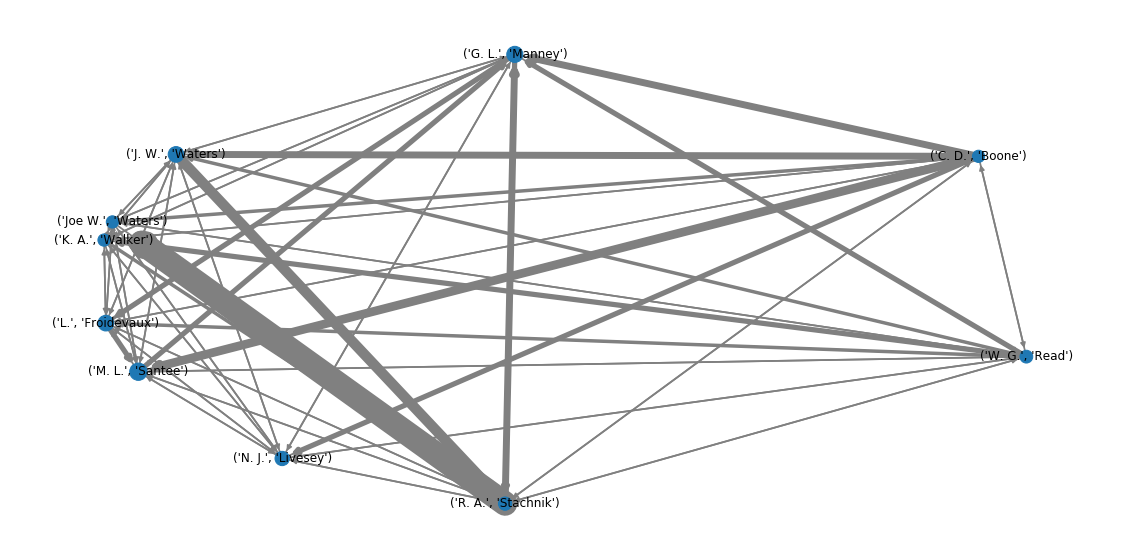

In [12]:
plt.figure(figsize=(20,10))
plt.axis('off')
pos = nx.shell_layout(G)
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
edgewidth = [0.15*d for d in edgewidth]
author_scores = list()
import copy 
nodes = copy.deepcopy(G.nodes)
for i in tqdm_notebook(nodes):
    if i in top[0]:
        index = top[0].index(i)
        author_scores.append(top[1][index])
    else:
        G.remove_node(i)
        
nx.draw_networkx_nodes(G, pos, node_size=[(i+1)*150 for i in author_scores])
nx.draw_networkx_edges(G, pos, width=edgewidth, edge_color="grey")
nx.draw_networkx_labels(G, pos=pos)

## Export for Visualization in D3.js

In [16]:
G_json = export_to_json(G)

In [17]:
with open("../visualization/data/chlorine_partitioning_mls_graph.json", 'w') as f_out:
    json.dump(G_json, f_out)

In [23]:
scores_json = dict()
for t in zip(top[0], top[1]):
    scores_json[" ".join(t[0])] = t[1]
scores_json

{'M. L. Santee': 1.0,
 'G. L. Manney': 0.7272727272727315,
 'J. W. Waters': 0.6363636363636479,
 'L. Froidevaux': 0.6363636363636479,
 'N. J. Livesey': 0.363636363636367,
 'R. A. Stachnik': 0.18181818181818427,
 'W. G. Read': 0.09090909090909166,
 'C. D. Boone': 0.0,
 'Joe W. Waters': 0.0,
 'K. A. Walker': 0.0}

In [24]:
with open("../visualization/data/chlorine_partitioning_mls_scores.json", 'w') as f_out:
    json.dump(scores_json, f_out)